# Overview:

This project is an analysis of the NY State Motor Vehicle Collisions dataset. The goals of this analysis are acertain the relation between time of day and vehicle collisions, and to find the most common vehicle damage from vehicular collisions in New York State.

# Data Acquistion and Cleaning

Data for this projected was gathered from the NYC Open Data API, it was then filtered for columns that were not pertient to analyzing the relationship between time of day and vehicle collisions, and vehile damages from collisions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json

# The API endpoint for the Motor Vehicle Collisions - Persons dataset
dataset_id_persons = 'bm4k-52h4'
base_url_persons = f'https://data.cityofnewyork.us/resource/{dataset_id_persons}.json'

# Parameters for the API request: removing $limit to fetch all data
params_persons = {
    '$order': 'collision_id DESC' # Still order by collision_id descending
}

print(f"Making API request to: {base_url_persons} with parameters: {params_persons}")

all_data_persons = []
offset = 0
limit_per_request = 100000 # Fetch in chunks due to API limits.

while True:
    current_params = params_persons.copy()
    current_params['$limit'] = limit_per_request
    current_params['$offset'] = offset

    try:
        response_persons = requests.get(base_url_persons, params=current_params)
        response_persons.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

        batch_data = response_persons.json()
        all_data_persons.extend(batch_data)

        print(f"Fetched {len(batch_data)} records (total: {len(all_data_persons)}) with offset {offset}.")

        if len(batch_data) < limit_per_request: # If  > limit_per_request it's the last page
            break
        offset += limit_per_request

    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        break
    except requests.exceptions.ConnectionError as conn_err:
        print(f"Connection error occurred: {conn_err}")
        break
    except requests.exceptions.Timeout as timeout_err:
        print(f"Timeout error occurred: {timeout_err}")
        break
    except requests.exceptions.RequestException as req_err:
        print(f"An unexpected error occurred: {req_err}")
        break
    except json.JSONDecodeError:
        print("Failed to decode JSON from response.")
        print(f"Response content: {response_persons.text}")
        break

print(f"Successfully fetched a total of {len(all_data_persons)} records from 'Motor Vehicle Collisions - Persons'.")

# Convert the fetched data into a pandas DataFrame
MVC = pd.DataFrame(all_data_persons)


#dropping unessesary columns
MVC_c1 = MVC.drop(['unique_id', 'collision_id', 'vehicle_id',
                   'vehicle_model', 'vehicle_year', 'vehicle_make',
                  'travel_direction', 'vehicle_occupants', 'driver_sex',
                  'driver_license_status', 'driver_license_jurisdiction',
                  'public_property_damage', 'public_property_damage_type'], axis = 1)



len(MVC_c1)

#convert CRASH_DATE from object data type to date
MVC_c1['crash_date'] = pd.to_datetime(MVC_c1['crash_date'])

MVC_c1.info()

#convert CRASH_TIME from object data type to datetime
MVC_c1['crash_time'] = pd.to_datetime(MVC_c1['crash_time'])

MVC_c1.info()

#convert remaining columns to strings for filtering
MVC_c1 = MVC_c1.astype({'state_registration': 'string',
                        'vehicle_type': 'string',
                        'pre_crash': 'string',
                        'point_of_impact': 'string',
                        'vehicle_damage': 'string',
                        'vehicle_damage_1': 'string',
                        'vehicle_damage_2': 'string',
                        'vehicle_damage_3': 'string',
                        'contributing_factor_1': 'string',
                        'contributing_factor_2': 'string',
                        })
len(MVC_c1)

#cleaning all non NY state registrations
MVC_c1 = MVC_c1[MVC_c1['state_registration'] == 'NY']
len(MVC_c1)

#clearing all dates before 2019
MVC_c1['crash_date'] = pd.to_datetime(MVC_c1['crash_date'])
# Correcting the filtering logic to keep dates from 2019-01-01 onwards
MVC_c1 = MVC_c1[MVC_c1['crash_date'] >= pd.to_datetime('2019-01-01')]
len(MVC_c1)
#1091177 entries

#Creating list of unqiue values in column to create dictionary of all contributing factors and a count of them
CONTRIBUTING_FACTOR_1_unqiue = MVC_c1['contributing_factor_1'].unique()
CONTRIBUTING_FACTOR_1_unqiue_list = CONTRIBUTING_FACTOR_1_unqiue.tolist()
print(CONTRIBUTING_FACTOR_1_unqiue_list)

CF1U_DICT = {}
for i in CONTRIBUTING_FACTOR_1_unqiue_list:
    if pd.isna(i):
        CF1U_DICT['NA'] = int(MVC_c1['contributing_factor_1'].isna().sum())
    else:
        CF1U_DICT[i] = int((MVC_c1['contributing_factor_1'] == i).sum())

del CF1U_DICT["Unspecified"]
del CF1U_DICT["NA"]
print(CF1U_DICT)

#Creating list of unqiue values in column to create dictionary of all contributing factors and a count of them
CONTRIBUTING_FACTOR_2_unqiue = MVC_c1['contributing_factor_2'].unique()
CONTRIBUTING_FACTOR_2_unqiue_list = CONTRIBUTING_FACTOR_2_unqiue.tolist()
print(CONTRIBUTING_FACTOR_2_unqiue_list)

CF2U_DICT = {}
for i in CONTRIBUTING_FACTOR_2_unqiue_list:
    if pd.isna(i):
        CF2U_DICT['NA'] = int(MVC_c1['contributing_factor_2'].isna().sum())
    else:
        CF2U_DICT[i] = int((MVC_c1['contributing_factor_2'] == i).sum())
del CF2U_DICT["Unspecified"]
del CF2U_DICT["NA"]
print(CF2U_DICT)

#Creating list of unqiue values in column to create dictionary of all vehicle damage types and a count of them
VEHICLE_DAMAGE_3_unqiue = MVC_c1['vehicle_damage_3'].unique()
VEHICLE_DAMAGE_3_unqiue_list = VEHICLE_DAMAGE_3_unqiue.tolist()
print(VEHICLE_DAMAGE_3_unqiue_list)

VD3_DICT = {}
for i in VEHICLE_DAMAGE_3_unqiue_list:
    if pd.isna(i):
        VD3_DICT['NA'] = int(MVC_c1['vehicle_damage_3'].isna().sum())
    else:
        VD3_DICT[i] = int((MVC_c1['vehicle_damage_3'] == i).sum())
del VD3_DICT["Other"]
del VD3_DICT["NA"]
print(VD3_DICT)

VEHICLE_DAMAGE_2_unqiue = MVC_c1['vehicle_damage_2'].unique()
VEHICLE_DAMAGE_2_unqiue_list = VEHICLE_DAMAGE_2_unqiue.tolist()
print(VEHICLE_DAMAGE_2_unqiue_list)

VD2_DICT = {}
for i in VEHICLE_DAMAGE_2_unqiue_list:
    if pd.isna(i):
        VD2_DICT['NA'] = int(MVC_c1['vehicle_damage_2'].isna().sum())
    else:
        VD2_DICT[i] = int((MVC_c1['vehicle_damage_2'] == i).sum())

del VD2_DICT["Other"]
del VD2_DICT["NA"]
print(VD2_DICT)

VEHICLE_DAMAGE_1_unqiue = MVC_c1['vehicle_damage_1'].unique()
VEHICLE_DAMAGE_1_unqiue_list = VEHICLE_DAMAGE_1_unqiue.tolist()
print(VEHICLE_DAMAGE_1_unqiue_list)

VD1_DICT = {}
for i in VEHICLE_DAMAGE_1_unqiue_list:
    if pd.isna(i):
        VD1_DICT['NA'] = int(MVC_c1['vehicle_damage_1'].isna().sum())
    else:
        VD1_DICT[i] = int((MVC_c1['vehicle_damage_1'] == i).sum())

del VD1_DICT["Other"]
del VD1_DICT["NA"]
print(VD1_DICT)

#Creating list of unqiue values in column to create dictionary of all pre crash conditions and a count of them
PRE_CRASH_unqiue = MVC_c1['pre_crash'].unique()
PRE_CRASH_unqiue_list = PRE_CRASH_unqiue.tolist()
print(PRE_CRASH_unqiue_list)

PC_DICT = {}
for i in PRE_CRASH_unqiue_list:
    if pd.isna(i):
        PC_DICT['NA'] = int(MVC_c1['pre_crash'].isna().sum())
    else:
        PC_DICT[i] = int((MVC_c1['pre_crash'] == i).sum())
del PC_DICT["Other*"]
del PC_DICT["NA"]
print(PC_DICT)

#Creating list of unqiue values in column to create dictionary of all vehicle types involved in crashes and a count of them
VEHICLE_TYPE_unqiue = MVC_c1['vehicle_type'].unique()
VEHICLE_TYPE_unqiue_list = VEHICLE_TYPE_unqiue.tolist()
print(VEHICLE_TYPE_unqiue_list)

VT_DICT = {}
for i in VEHICLE_TYPE_unqiue_list:
    if pd.isna(i):
        VT_DICT['NA'] = int(MVC_c1['vehicle_type'].isna().sum())
    else:
        VT_DICT[i] = int((MVC_c1['vehicle_type'] == i).sum())

print(VT_DICT)


Making API request to: https://data.cityofnewyork.us/resource/bm4k-52h4.json with parameters: {'$order': 'collision_id DESC'}
Fetched 100000 records (total: 100000) with offset 0.
Fetched 100000 records (total: 200000) with offset 100000.
Fetched 100000 records (total: 300000) with offset 200000.
Fetched 100000 records (total: 400000) with offset 300000.
Fetched 100000 records (total: 500000) with offset 400000.
Fetched 100000 records (total: 600000) with offset 500000.
Fetched 100000 records (total: 700000) with offset 600000.
Fetched 100000 records (total: 800000) with offset 700000.
Fetched 100000 records (total: 900000) with offset 800000.
Fetched 100000 records (total: 1000000) with offset 900000.
Fetched 100000 records (total: 1100000) with offset 1000000.
Fetched 100000 records (total: 1200000) with offset 1100000.
Fetched 100000 records (total: 1300000) with offset 1200000.
Fetched 100000 records (total: 1400000) with offset 1300000.
Fetched 100000 records (total: 1500000) with

/tmp/ipython-input-738618830.py:80: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MVC_c1['crash_time'] = pd.to_datetime(MVC_c1['crash_time'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4468295 entries, 0 to 4468294
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   crash_date             datetime64[ns]
 1   crash_time             datetime64[ns]
 2   state_registration     object        
 3   vehicle_type           object        
 4   pre_crash              object        
 5   point_of_impact        object        
 6   vehicle_damage         object        
 7   vehicle_damage_1       object        
 8   vehicle_damage_2       object        
 9   vehicle_damage_3       object        
 10  contributing_factor_1  object        
 11  contributing_factor_2  object        
dtypes: datetime64[ns](2), object(10)
memory usage: 409.1+ MB
['Unspecified', 'Turning Improperly', 'Driver Inattention/Distraction', 'Driver Inexperience', 'Failure to Yield Right-of-Way', 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion', 'Alcohol Involvement', 'Other Vehicula

# Data Visualization

Using the library matplotlib.pyplot the data was visulized to show relationships present in the data used in the statistical analysis.

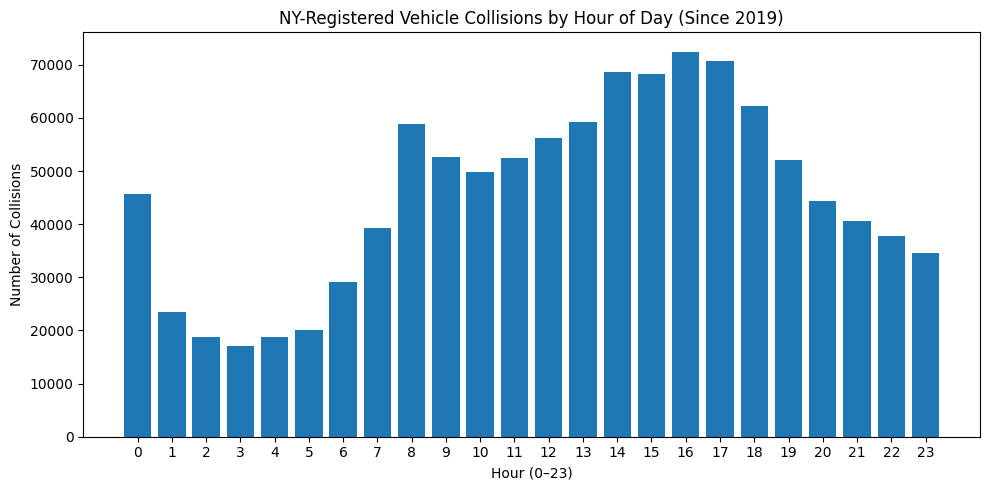

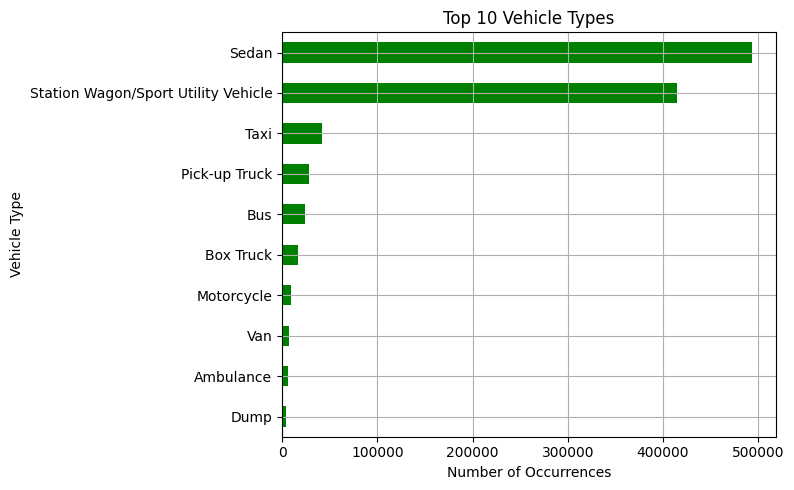

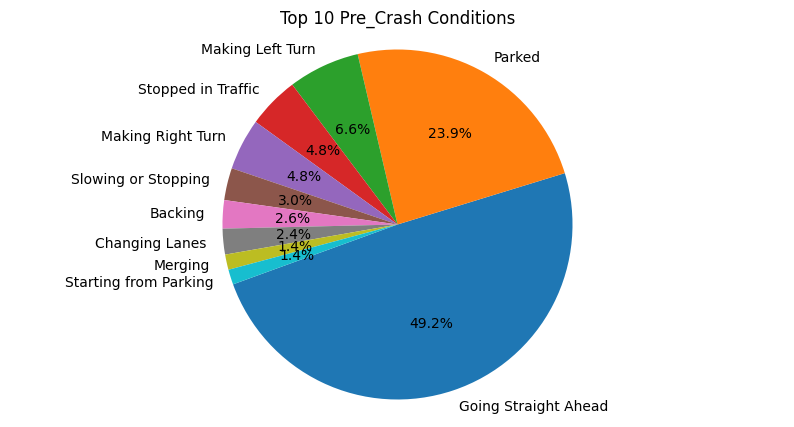

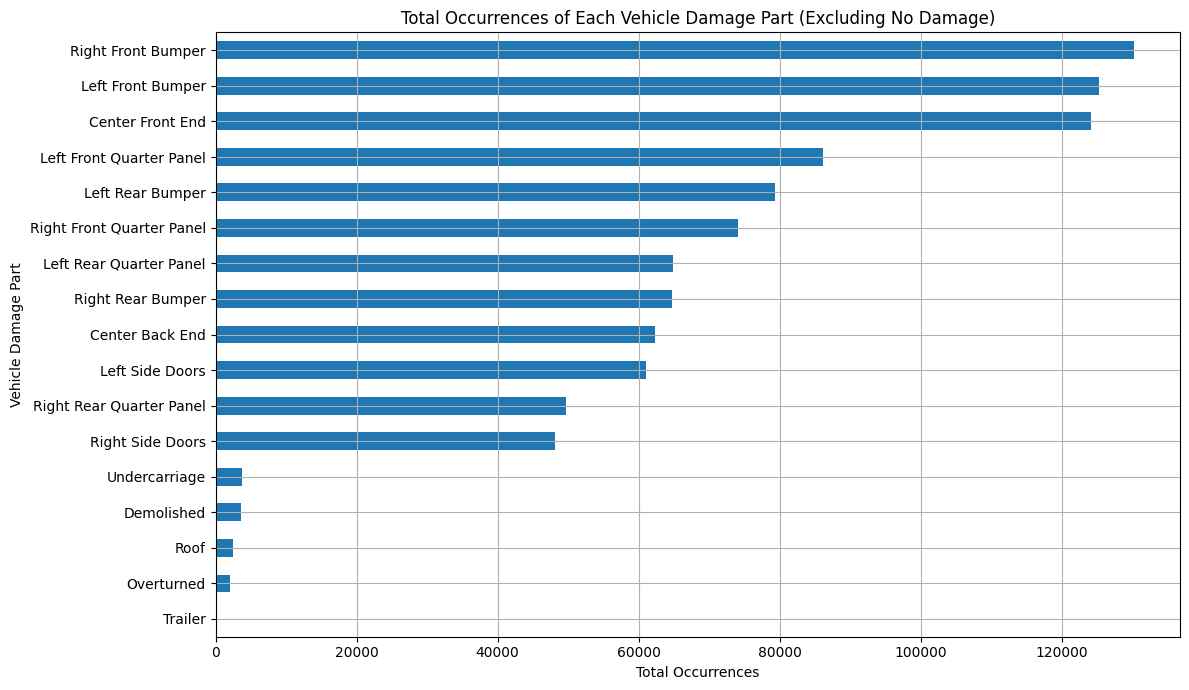

In [ ]:
#Creating barchart of number of collisions by hours of the day
MVC_c1 = MVC_c1.dropna(subset=['crash_time'])


MVC_c1['HOUR'] = MVC_c1['crash_time'].dt.hour
hour_counts = MVC_c1['HOUR'].value_counts().sort_index()


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(hour_counts.index, hour_counts.values)


ax.set_title("NY-Registered Vehicle Collisions by Hour of Day (Since 2019)")
ax.set_xlabel("Hour (0–23)")
ax.set_ylabel("Number of Collisions")
ax.set_xticks(range(0, 24))


fig.set_size_inches(10, 5)
plt.tight_layout()
plt.show()

# Define vehicle_type_counts and pre_crash_counts here
vehicle_type_counts = MVC_c1["vehicle_type"].value_counts()
pre_crash_counts = MVC_c1["pre_crash"].value_counts()

#Creating a bar chart for Top 10 Vehicle Types.
plt.figure(figsize=(8, 5))
vehicle_type_counts.head(10).sort_values().plot(kind="barh", color= "green", grid=True)
plt.title("Top 10 Vehicle Types")
plt.xlabel("Number of Occurrences")
plt.ylabel("Vehicle Type")
plt.tight_layout()
plt.show()


#Creating the Pie chart for Top 10 Pre_crash conditions.
plt.figure(figsize=(10, 5))
plt.pie(pre_crash_counts.head(10), labels=pre_crash_counts.head(10).index, autopct="%1.1f%%", startangle=200)
plt.title("Top 10 Pre_Crash Conditions")
plt.axis("equal")
plt.show()


#Combine the damage dictionaries
combined_damage_counts = {}


for d_dict in [VD1_DICT, VD2_DICT, VD3_DICT]:
    for damage_type, count in d_dict.items():
        combined_damage_counts[damage_type] = combined_damage_counts.get(damage_type, 0) + count


damage_series = pd.Series(combined_damage_counts)


#Filter out 'No Damage' and creating the horizontal bar chart for 'Total Occurrences of Each Vehicle Damage Part'
damage_series = damage_series[damage_series.index != "No Damage"]
damage_series = damage_series.sort_values()


plt.figure(figsize=(12, 7))
damage_series.plot(kind="barh", grid=True)
plt.title("Total Occurrences of Each Vehicle Damage Part (Excluding No Damage)")
plt.xlabel("Total Occurrences")
plt.ylabel("Vehicle Damage Part")
plt.tight_layout()
plt.show()


# Statistical Analysis of NY State Motor Vehicle Collisions


In [ ]:
# 1) Basic counts
print("Total records after cleaning:", len(MVC_c1))

print("\nCounts by vehicle type (top 10):")
vehicle_type_counts = MVC_c1["vehicle_type"].value_counts()
print(vehicle_type_counts.head(10))

print("\nCounts by primary contributing factor (top 10):")
cf1_counts = MVC_c1["contributing_factor_1"].value_counts()
print(cf1_counts.head(10))

print("\nCounts by pre-crash action (top 10):")
pre_crash_counts = MVC_c1["pre_crash"].value_counts()
print(pre_crash_counts.head(10))


# 2) Min, max, range, std dev for crashes per day

# crashes per day
daily_counts = MVC_c1.groupby("crash_date").size()
# basic stats
daily_min = daily_counts.min()
daily_max = daily_counts.max()
daily_range = daily_max - daily_min
daily_mean = daily_counts.mean()
daily_std = daily_counts.std()

print("\n--- Crashes per day ---")
print("Min crashes in a day:", int(daily_min))
print("Max crashes in a day:", int(daily_max))
print("Range (max - min):", int(daily_range))
print("Mean crashes per day:", round(daily_mean, 2))
print("Standard deviation (crashes per day):", round(daily_std, 2))


# 3) Time-of-day analysis (distribution + std dev)

# ensure CRASH_TIME is datetime and create an hour column
MVC_c1["CRASH_HOUR"] = MVC_c1["crash_time"].dt.hour

hour_counts = MVC_c1["CRASH_HOUR"].value_counts().sort_index()
hour_std = MVC_c1["CRASH_HOUR"].std()

print("\n--- Crash distribution by hour of day (0-23) ---")
print(hour_counts)

print("\nStandard deviation of crash hour:", round(hour_std, 2))

# busiest and quietest hours
busiest_hour = hour_counts.idxmax()
busiest_hour_count = hour_counts.max()
quietest_hour = hour_counts.idxmin()
quietest_hour_count = hour_counts.min()

print("\nBusiest crash hour:", busiest_hour, "with", int(busiest_hour_count), "crashes")
print("Quietest crash hour:", quietest_hour, "with", int(quietest_hour_count), "crashes")


# 4) Outliers in daily crash counts (days with unusually high crashes)

# define outlier threshold as mean + 3 * std
outlier_threshold = daily_mean + 3 * daily_std
outlier_days = daily_counts[daily_counts > outlier_threshold]

print("\n--- Outlier days (crashes per day > mean + 3*std) ---")
print("Outlier threshold:", round(outlier_threshold, 2))
print("Number of outlier days:", len(outlier_days))
if len(outlier_days) > 0:
    print(outlier_days.sort_values(ascending=False).head(10))


# 5) "Interesting" statistics from the dataset

# top vehicle type
if not vehicle_type_counts.empty:
    top_vehicle_type = vehicle_type_counts.index[0]
    top_vehicle_type_count = int(vehicle_type_counts.iloc[0])
    print("\nMost common vehicle type:", top_vehicle_type, "with", top_vehicle_type_count, "records")

# top contributing factor
if not cf1_counts.empty:
    top_cf1 = cf1_counts.index[0]
    top_cf1_count = int(cf1_counts.iloc[0])
    print("Most common primary contributing factor:", top_cf1, "with", top_cf1_count, "records")

# top pre-crash action
if not pre_crash_counts.empty:
    top_pre_crash = pre_crash_counts.index[0]
    top_pre_crash_count = int(pre_crash_counts.iloc[0])
    print("Most common pre-crash action:", top_pre_crash, "with", top_pre_crash_count, "records")

# share of crashes in busiest hour vs total
total_crashes = len(MVC_c1)
if total_crashes > 0:
    busiest_share = busiest_hour_count / total_crashes
    print("\nShare of all crashes that occur in the busiest hour:",
          round(busiest_share * 100, 2), "%")

# share of top vehicle type
if total_crashes > 0 and not vehicle_type_counts.empty:
    top_vehicle_type_share = top_vehicle_type_count / total_crashes
    print("Share of crashes involving the most common vehicle type:",
          round(top_vehicle_type_share * 100, 2), "%")


Total records after cleaning: 1093355

Counts by vehicle type (top 10):
vehicle_type
Sedan                                  493798
Station Wagon/Sport Utility Vehicle    414260
Taxi                                    42382
Pick-up Truck                           27987
Bus                                     24064
Box Truck                               16291
Motorcycle                               8961
Van                                      7101
Ambulance                                5754
Dump                                     4037
Name: count, dtype: Int64

Counts by primary contributing factor (top 10):
contributing_factor_1
Unspecified                       636373
Driver Inattention/Distraction    151241
Following Too Closely              46141
Failure to Yield Right-of-Way      41893
Other Vehicular                    27138
Passing or Lane Usage Improper     22695
Backing Unsafely                   19223
Passing Too Closely                17919
Unsafe Lane Changing          

# Exporting Data as a SQLite Database

In [ ]:
import sqlite3

# 1. Create / connect to a SQLite database file
# This will create mvc_clean.db in your working directory if it doesn't exist
conn = sqlite3.connect("mvc_clean.db")

# 2. Export the cleaned DataFrame to a table named 'mvc_clean'
MVC_c1.to_sql("mvc_clean", conn, if_exists="replace", index=False)

# 3. Read back a small sample to verify it worked
check_df = pd.read_sql("SELECT * FROM mvc_clean LIMIT 5;", conn)
print(check_df)

# 4. Close the connection
conn.close()




            crash_date           crash_time state_registration  \
0  2025-11-30 00:00:00  2025-12-13 22:49:00                 NY   
1  2025-12-09 00:00:00  2025-12-13 15:01:00                 NY   
2  2025-12-09 00:00:00  2025-12-13 15:01:00                 NY   
3  2025-12-06 00:00:00  2025-12-13 17:42:00                 NY   
4  2025-12-06 00:00:00  2025-12-13 17:42:00                 NY   

                          vehicle_type             pre_crash  \
0  Station Wagon/Sport Utility Vehicle  Going Straight Ahead   
1                                Sedan     Making Right Turn   
2  Station Wagon/Sport Utility Vehicle     Making Right Turn   
3                                Sedan  Going Straight Ahead   
4                                Sedan  Going Straight Ahead   

            point_of_impact            vehicle_damage  \
0  Right Rear Quarter Panel  Right Rear Quarter Panel   
1           Center Back End           Center Back End   
2        Right Front Bumper        Right Front 